In [1]:
# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

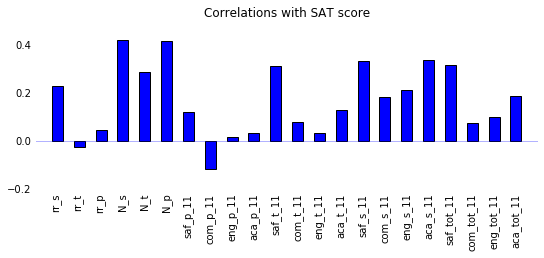

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

fig, ax = plt.subplots(figsize=(9,3))
positions = np.arange(len(correlations[survey_fields]))+0.75
xticks = positions + 0.25
ax.bar(positions, correlations[survey_fields], 0.5)
ax.set_xticks(xticks)
ax.set_yticks(np.arange(-0.2,0.6,0.2))
ax.set_xlim(0,23)
ax.set_xticklabels(survey_fields, rotation=90)
ax.tick_params(bottom="off", top="off", left="off", right="off")
ax.axhline(0, alpha=0.3)
ax.set_title('Correlations with SAT score')
for i, spine in ax.spines.items():
    spine.set_visible(False)
    

#### Teacher response rate is slightly negative in terms of correlation with SAT score, probably not significant. Communication score based on parents response has a stronger negative correlation with SAT score. 


# Scatter plot safety vs. SAT scores

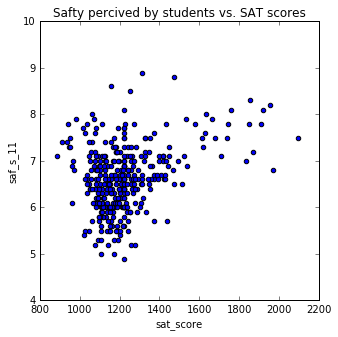

In [13]:
ax = combined.plot(x='sat_score', y='saf_s_11', kind='scatter', title='Safty percived by students vs. SAT scores', figsize=(5,5))

### Safety perceived by students appear to have a positive correlation with SAT scores

# Map safety scores in each school district

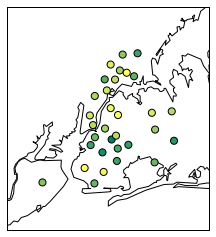

In [18]:
school_dist_group = combined.groupby('school_dist').agg(np.mean)
school_dist_group.reset_index(inplace=True)
lat_min = school_dist_group.describe().loc['min','lat']-0.1
lat_max = school_dist_group.describe().loc['max','lat']+0.1
lon_min = school_dist_group.describe().loc['min','lon']-0.1
lon_max = school_dist_group.describe().loc['max','lon']+0.1
#print(lat_min, lat_max, lon_min, lon_max)
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='h')


m.drawcoastlines()
m.drawmapboundary()
m.drawrivers()

#print(school_dist_group['lon'], school_dist_group['lat'])
m.scatter(school_dist_group['lon'].tolist(), school_dist_group['lat'].tolist(), s=50, c=school_dist_group['saf_s_11'], latlon=True, zorder=2, cmap='summer')
plt.show()

### Schools in Brooklyn has lower scores of safety comparing to Manhattan. 

# Racial difference in SAT scores

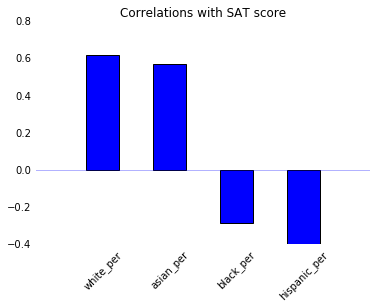

In [24]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]
positions = np.arange(len(races)) + 0.75
fig,ax = plt.subplots()

ax.bar(positions, correlations[races], 0.5)

xticks = positions + 0.25

ax.set_xticks(xticks)
ax.set_yticks(np.arange(-0.4,0.8,0.2))
ax.set_xlim(0,5)
ax.set_xticklabels(races, rotation=45)
ax.tick_params(bottom="off", top="off", left="off", right="off")
ax.axhline(0, alpha=0.3)
ax.set_title('Correlations with SAT score')
for i, spine in ax.spines.items():
    spine.set_visible(False)

### Percentages of Asian students and white students correlate positively with SAT scores, and black students and hispanic students negatively. SAT is not a fair measure for all racial groups' academic achievement. 

# Hispanic percentage vs. SAT scores

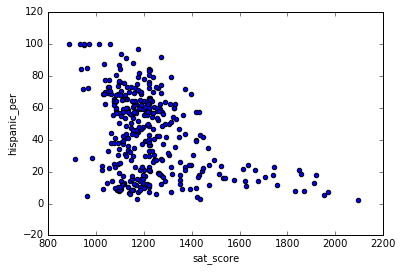

In [28]:
combined.plot(x='sat_score', y='hispanic_per', kind='scatter')

### Schools with high Hispanic percentage perform lower in SAT scores.  

# Examine schools with Hispanic percentage larger than 95%

In [36]:
print(combined.loc[combined['hispanic_per']>95, 'SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### These schools are mostly international schools. 

# Examine schools with Hispanic percentage less than 95% and average SAT greater than 1800

In [37]:
print(combined[combined['hispanic_per']<10].loc[combined['sat_score']>1800, 'SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### These are elite highschools that specialize in STEM

# Investigate gender difference

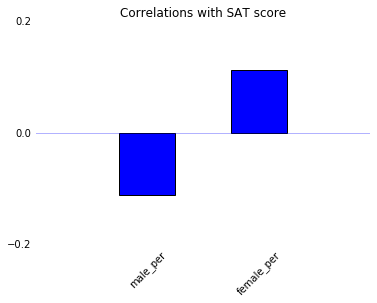

In [45]:
genders = ["male_per", "female_per"]
positions = np.arange(len(genders)) + 0.75
fig,ax = plt.subplots()

ax.bar(positions, correlations[genders], 0.5)

xticks = positions + 0.25

ax.set_xticks(xticks)
ax.set_yticks(np.arange(-0.2,0.4,0.2))
ax.set_xlim(0,3)
ax.set_ylim(-0.2,0.2)
ax.set_xticklabels(genders, rotation=45)
ax.tick_params(bottom="off", top="off", left="off", right="off")
ax.axhline(0, alpha=0.3)
ax.set_title('Correlations with SAT score')
for i, spine in ax.spines.items():
    spine.set_visible(False)

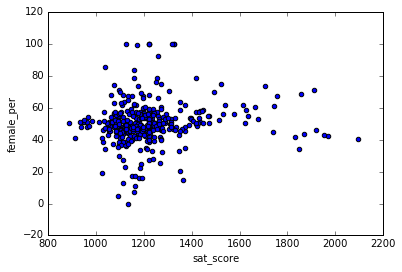

In [46]:
combined.plot(x='sat_score', y='female_per', kind='scatter')

### Female students in general perform better than male students

In [49]:
print('Below is a list of highschools with female students greater than 60% and SAT average score greater than 1700')
print(combined[combined['female_per']<60].loc[combined['sat_score']>1700, 'SCHOOL NAME'])

Below is a list of highschools with female students greater than 60% and SAT average score greater than 1700
37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### These appear to be STEM schools

# AP test takers 

In [51]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined['ap_per']

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
5      0.209123
6      0.741545
7      0.297988
8      0.376177
9      0.307945
10     0.050725
11     0.229698
12     0.093126
13     0.080128
14     0.384014
15     0.341346
16     0.260664
17     0.297988
18     0.388641
19     0.424437
20     0.528807
21     0.152798
22     0.039841
23     0.180556
24     0.196891
25     0.295938
26     0.305720
27     0.137380
28     0.306482
29     0.115385
         ...   
333    0.029536
334    0.084567
335    0.877747
336    0.053398
337    0.268251
338    0.260664
339    0.307945
340    0.082513
341    0.119905
342    0.142857
343    0.055616
344    0.127682
345    0.143466
346    0.293247
347    0.242535
348    0.316247
349    0.123853
350    0.036117
351    0.090191
352    0.096787
353    0.102194
354    0.086031
355    0.191154
356    0.478261
357    0.356433
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 36